In [3]:
import adddeps
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from scipy.stats import norm,normaltest, probplot

import pandas as pd
import sqlalchemy
from collections import defaultdict
import datetime
import importlib
from simulator.magnetic import SimulatorMagnetic
from simulator.models import Client, SimulationAlchemy as Simulation
from tqdm.notebook import tqdm

import multiprocessing
from multiprocessing import Pool, cpu_count

from relaxation.estimators import relaxation_finder_collision
import logging
import sys, os
from settings import DFS_PATH
from utils.utils import plot_mean_std, delete_dfs, smoothen, concat
from utils.ACfunctions import AC


matplotlib.rcParams["figure.dpi"] = 150
matplotlib.rcParams["axes.grid"] = True
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
client = Client()

In [4]:
def get_subdf(df, t, wide, zero_index=True, sp=1):
    df1 = df.loc[t-wide/2:t+wide/2:sp]
    if zero_index:
        df1.set_index(df1.index - df1.index[0], inplace=True)
    return df1

In [5]:
groups = [
    "ER 3.632.065.lammps",
    "ER 3.632.078.lammps",
    "ER 3.632.086.lammps",
    "ER 3.632.092.lammps",
    "ER 3.632.098.lammps",
    "ER 3.632.110.lammps"]

In [6]:
groups = [
    "ER 3.632.038.longer.lammps"
]

In [7]:
data = {}
for group in groups:
    items = client.get_simulation_groups([group])[:]
    [item.load_df() for item in tqdm(items)];
    data[group] = items

  0%|          | 0/404 [00:00<?, ?it/s]

In [10]:
items = data[groups[0]]
# [item.load_df() for item in tqdm(items)];
item = items[0]

In [11]:
item.E_init**2

273528.9954914041

In [12]:
df_L

NameError: name 'df_L' is not defined

In [13]:
def process(items):
    item = items[0]
    dt = item.record_interval
    shift = 5000
    potential_a = (1/item.a + 1/item.b)/2
    eps = (1/item.b - 1/item.a)/2/potential_a
    
    potential_a, eps, item.eccentricity**2/4
    
    df_L = concat([smoothen(item.df[["L"]],-1).L for item in items])
    df_L.set_index(df_L.index-shift, inplace=True)
    df_L = df_L.loc[25000:]
    
    ac = np.mean([AC(df_L[col].values) for col in df_L.columns], axis=0)

    ts = np.arange(len(ac)) * dt
    
    t=24000
    
    filt = (ts<t)&(t/3<ts)
    slope, _ = np.polyfit(ts[filt], np.log(ac[filt]), deg=1)
    alpha = - slope
    
    t = int(1./alpha)
    
    filt = (ts<t)&(0*t/3<ts)
    slope, _ = np.polyfit(ts[filt], np.log(ac[filt]), deg=1)
    alpha = - slope
    
    gamma = - 4 * potential_a**2 * eps**2 / slope; 
    
    dt
    T = ts[-1]

    omegas = np.arange(0, len(df_L)) * 2 * np.pi / T

    L_fft =  np.fft.fft(df_L.values, axis=0)

    L_spect = (dt**2 / T) * np.mean(np.abs(L_fft)**2, axis=1)
    
    tmp = df_L.loc[2*t:].std(axis=0) 
    C0 = tmp.mean()
    C0_std = tmp.std()
    
    return {"gamma":gamma, "alpha":alpha, "eps":eps, "e": item.eccentricity, 
           "spectr":pd.DataFrame({"omega": omegas, "S":L_spect}).set_index("omega"),
           "C":pd.DataFrame({"t": ts, "C":ac, "t1": ts*alpha}).set_index("t", drop=False)}

    

In [14]:
procs = [process(items) for items in tqdm(data.values())]

  0%|          | 0/1 [00:00<?, ?it/s]

In [221]:
import pickle


In [222]:
with open("CSdata.pkl", "wb") as f:
    pickle.dump(procs, f)

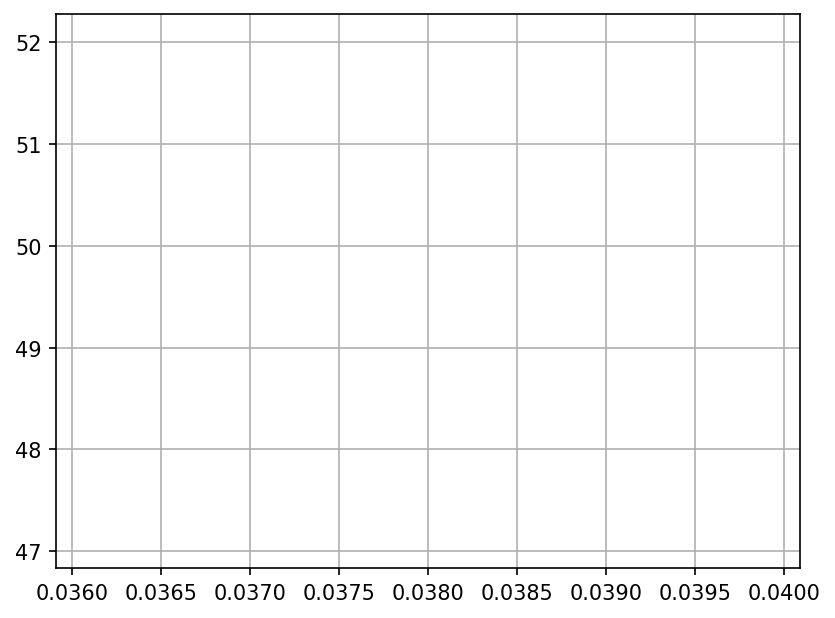

In [15]:
# plt.plot(
# [proc["e"] for proc in procs],
# [proc["C0"] for proc in procs],
# )
plt.plot(
[proc["e"] for proc in procs],
[proc["C"].iloc[0]["C"]**0.5 for proc in procs],
)
# plt.plot(
# [proc["e"] for proc in procs],
# [proc["C0"]+proc["C0_sdt"]/600**0.5 for proc in procs],
# )

In [35]:
df = procs[0]["C"]

In [36]:
df

,t,C,t1
t,,,
0.0,0.0,2455.600500,0.000000
5.0,5.0,2455.605347,0.000030
10.0,10.0,2455.609134,0.000060
15.0,15.0,2455.612196,0.000090
20.0,20.0,2455.612895,0.000120
...,...,...,...
574980.0,574980.0,73.901289,3.448127
574985.0,574985.0,73.834893,3.448157
574990.0,574990.0,73.742065,3.448187


In [70]:
df1 = df.loc[10000:200000]
x = df1["t"]
y = np.log(df1["C"])

In [71]:
slope, _ = np.polyfit(x, y, deg=1)

In [72]:
gamma = - 4 * potential_a**2 * eps**2 / slope; 

In [73]:
gamma

0.003601873386988914

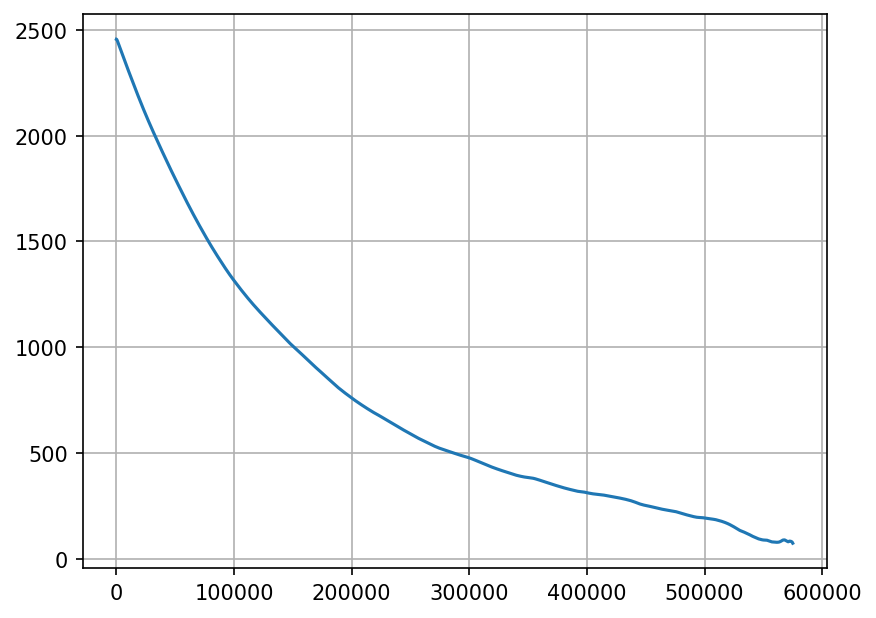

In [69]:
df1 = df.loc[:]
plt.plot(df1["t"], df1["C"])
# plt.yscale("log")

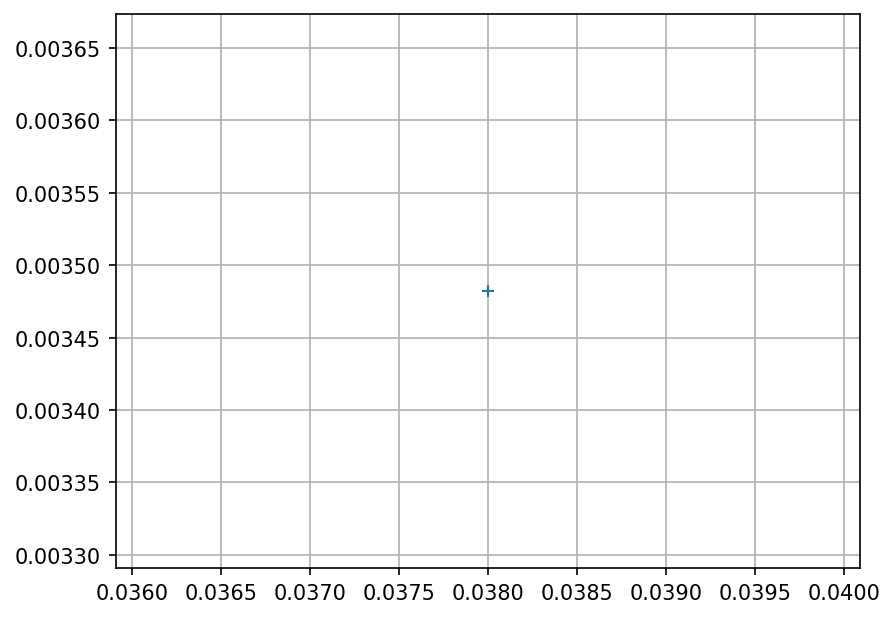

In [16]:
plt.plot(
[proc["e"] for proc in procs],
[proc["gamma"] for proc in procs],marker="+", ls="--"
)

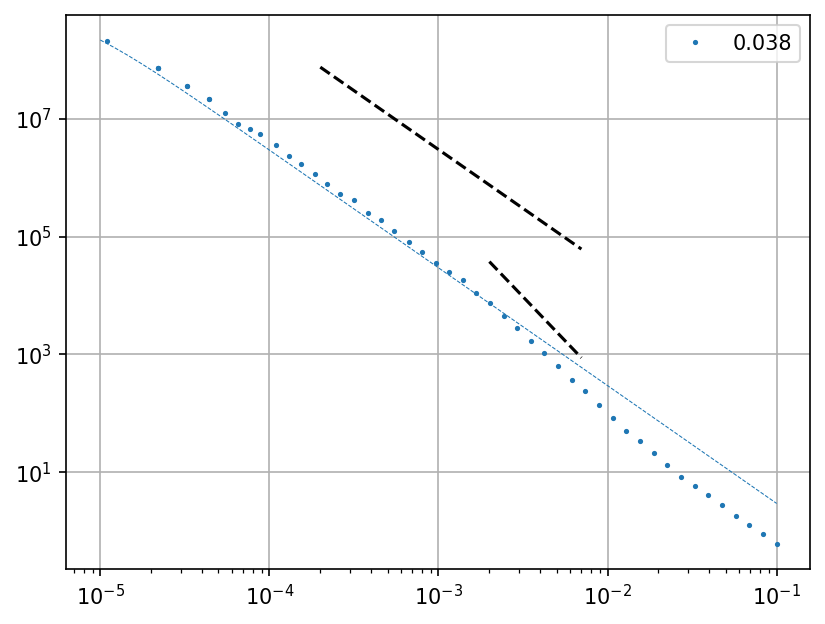

In [17]:
proc = procs[0]
ax = plt.subplot(111)
i=0
for proc, c in zip(procs, colors):
    alpha = proc["alpha"]
    df =  proc["spectr"].loc[:0.1].iloc[1:]
    
    
    
    
    
    omegas = np.logspace(np.log10(1e-5), np.log10(df.index[-1]))
    
    plt.plot(omegas, proc["C"].iloc[0]["C"] * 2* alpha / (alpha**2 + omegas**2),
             color=c, lw=0.5, ls="--")
    
    
    omega_target = np.logspace(np.log10(df.index[0]), np.log10(df.index[-1]), 50+i)
    ids = np.searchsorted(df.index+1e-7, omega_target)
    df = df.iloc[ids]
    
    plt.plot(df.index, df["S"], lw=0, marker=".",ms=3,color=c,  label=f"{proc['e']:0.3f}")
    
#     i-=2

omegas = np.array([2e-4,7e-3])
plt.plot(omegas, 3e-0 * omegas ** (-2), "--", color="black")


omegas = np.array([2e-3,7e-3])
plt.plot(omegas, 3e-4 * omegas ** (-3), "--", color="black",)


plt.xscale("log")
plt.yscale("log")
# plt.legend([proc["e"] for proc in procs])

plt.legend()

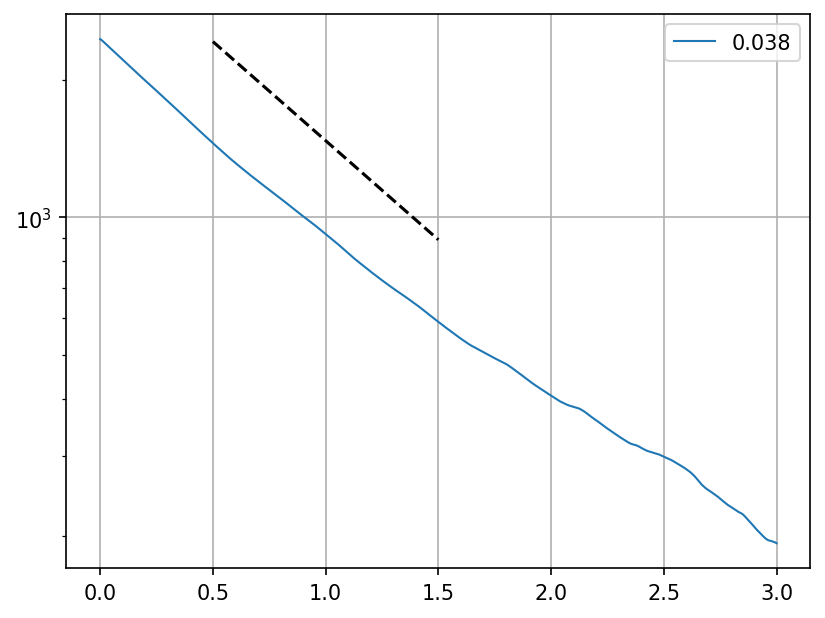

In [18]:
proc = procs[0]
ax = plt.subplot(111)
for proc in procs:
    df = proc["C"]
    df = df[df["t1"]<3]
    plt.plot(df["t1"], df["C"], lw=1)

plt.legend([proc["e"] for proc in procs])
plt.yscale("log")

ts = np.array([0.5,1.5])
plt.plot(ts, 4e3*np.exp(-ts), "--", color="black")


# plt.ylim(10, 3000)

In [20]:
item = items[0]
dt = item.record_interval
shift = 5000
potential_a = (1/item.a + 1/item.b)/2
eps = (1/item.b - 1/item.a)/2/potential_a
potential_a, eps, item.eccentricity**2/4

(0.20000001305094345, 0.0003612608774673922, 0.000361)

In [25]:
df_L = concat([smoothen(item.df[["L"]],-1).L for item in items])
df_L.set_index(df_L.index-shift, inplace=True)

In [26]:
ac = np.mean([AC(df_L[col].loc[40000:].values) for col in df_L.columns], axis=0)

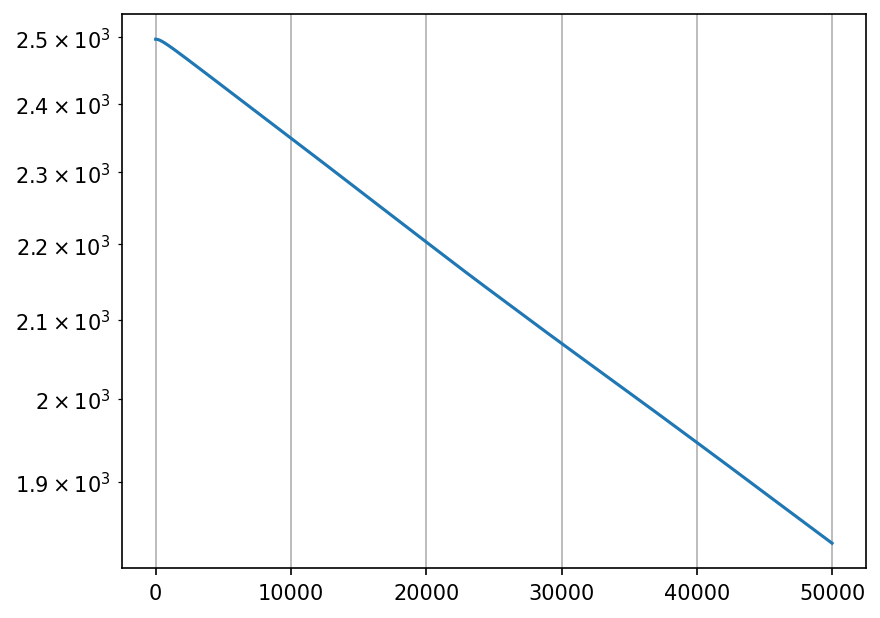

In [27]:
ts = np.arange(0, len(ac))* dt
plt.plot(ts[:10000],ac[:10000])
plt.yscale("log")

In [28]:
t=24000
filt = (ts<t)&(t/3<ts)
slope, _ = np.polyfit(ts[filt], np.log(ac[filt]), deg=1)
alpha = - slope

gamma = - 4 * potential_a**2 * eps**2 / slope; 

print(alpha, alpha**-1)
print(gamma, gamma**-1)

6.409428018330517e-06 156020.1623514719
0.00325793660833319 306.9427432818023


In [29]:
df_L.loc[int(2/alpha):].std(axis=1).mean()

52.61539373257164

In [30]:
( (2 * item.E_init**2) / (9 * potential_a**2 * item.particles) )

2905.5551284607295

In [31]:
df_xy = concat([smoothen(item.df[["xy"]],-1).xy for item in items])
df_xy.set_index(df_xy.index-shift, inplace=True)

In [32]:
df_O = concat([smoothen(item.df[["omega_MLE"]],2*np.pi/a).omega_MLE for item in items])
df_O.set_index(df_O.index-shift, inplace=True)

NameError: name 'a' is not defined

In [ ]:
df_Oraw = concat([smoothen(item.df[["omega_MLE"]],-2*np.pi/a).omega_MLE for item in items])
df_Oraw.set_index(df_Oraw.index-shift, inplace=True)

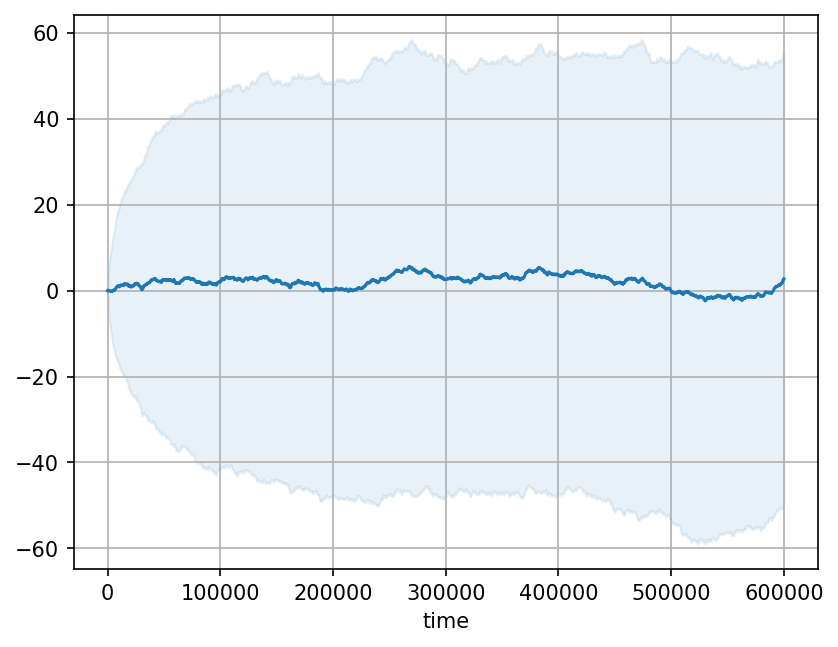

In [33]:
plot_mean_std(df_L.loc[0:1000000])

In [27]:
dt
T = df_L.index[-1]

omegas = np.arange(0, len(df_L)) * 2 * np.pi / T

L_fft = (dt**2 / T) * np.fft.fft(df_L.values, axis=0)

L_spect = np.mean(np.abs(L_fft)**2, axis=1)

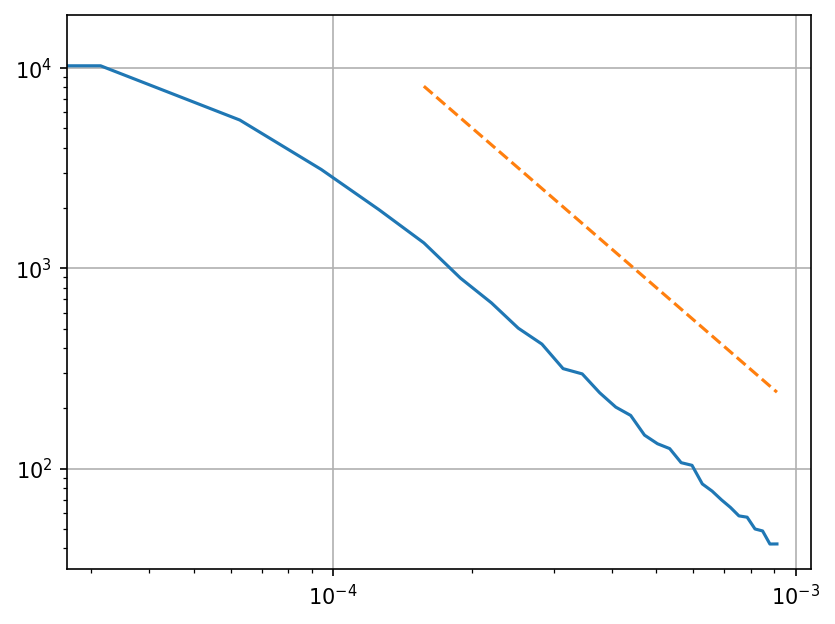

In [31]:
W = 30
plt.plot(omegas[:W], L_spect[:W])
plt.plot(omegas[5:W], 2e-4 * omegas[5:W] ** (-2), "--", "k")
plt.xscale("log")
plt.yscale("log")